## Testing and preparing initial conditions for Basilisk

### Main functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FigureWidth = 3.375
factor = 3
# Set global parameters
params = {
          'lines.linewidth': 3,
          'axes.labelsize': int(9*factor),
          'legend.fontsize': int(6.5*factor),
          'xtick.labelsize': int(9*factor),
          'ytick.labelsize': int(9*factor),
          'text.usetex': True,
          'font.family': 'serif'}
plt.rcParams.update(params)
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath}"

def prepare_plot(params):
    fig, ax = plt.subplots(figsize=(FigureWidth*(factor+1), FigureWidth*(factor+1)/2))
    ax.set_xlim(params["Rmin"], params["Rmax"])
    ax.set_ylim(params["Zmin"], params["Zmax"])
    ax.set_xlabel(r'$r/R_0$')
    ax.set_ylabel(r'$z/R_0$')
    ax.set_aspect('equal')
    return fig, ax

def load_and_sort_data(file_path):
    df = pd.read_csv(file_path)
    r = df["r/mm"].values
    z = df["z/mm"].values
    dz_dr = np.arctan2(np.gradient(z), np.gradient(r))
    sorted_indices = np.argsort(dz_dr)
    return r[sorted_indices], z[sorted_indices], dz_dr[sorted_indices]

def calculate_closest_approach(r1, z1, r2, z2):
    distances = np.sqrt((r1[:, None] - r2)**2 + (z1[:, None] - z2)**2)
    min_dist_index = np.unravel_index(np.argmin(distances), distances.shape)
    return min_dist_index, distances[min_dist_index]

def extract_and_combine_segments(r_ca, z_ca, ang_ca, r_bb, z_bb, ang_bb, min_dist_index):
    """
    Extracts segments from the given arrays based on the point of closest approach
    and combines them to form new arrays.

    Parameters:
    r_ca (array): Radial coordinates array for the first segment.
    z_ca (array): Axial coordinates array for the first segment.
    ang_ca (array): Angular coordinates array for the first segment.
    r_bb (array): Radial coordinates array for the second segment.
    z_bb (array): Axial coordinates array for the second segment.
    ang_bb (array): Angular coordinates array for the second segment.
    min_dist_index (tuple): Tuple containing the indices of the closest approach points for both segments.

    Returns:
    tuple: Combined arrays for radial, axial, and angular coordinates.
    """

    closest_index_ca = min_dist_index[0]
    closest_index_bb = min_dist_index[1]

    r_segment_ca = r_ca[:closest_index_ca + 1]
    z_segment_ca = z_ca[:closest_index_ca + 1]
    ang_segment_ca = ang_ca[:closest_index_ca + 1]

    r_segment_bb = r_bb[closest_index_bb:]
    z_segment_bb = z_bb[closest_index_bb:]
    ang_segment_bb = ang_bb[closest_index_bb:]

    r_bubble = np.concatenate((r_segment_ca, r_segment_bb))
    z_bubble = np.concatenate((z_segment_ca, z_segment_bb))
    ang_bubble = np.concatenate((ang_segment_ca, ang_segment_bb))

    return r_bubble, z_bubble, ang_bubble

### finding typical length scale of the problem: based on the volume of the injected air bubble



* OA is coating-air
* OW is bulk-bubble
* WA is bulk-ambient

### Case I: CaseI_VeryThinLayer_PEO0.2wt%

Volume =  24.138741950664684
Requiv =  1.7928419584511264


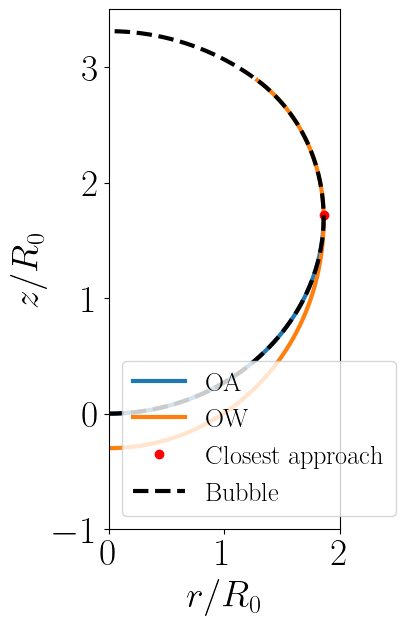

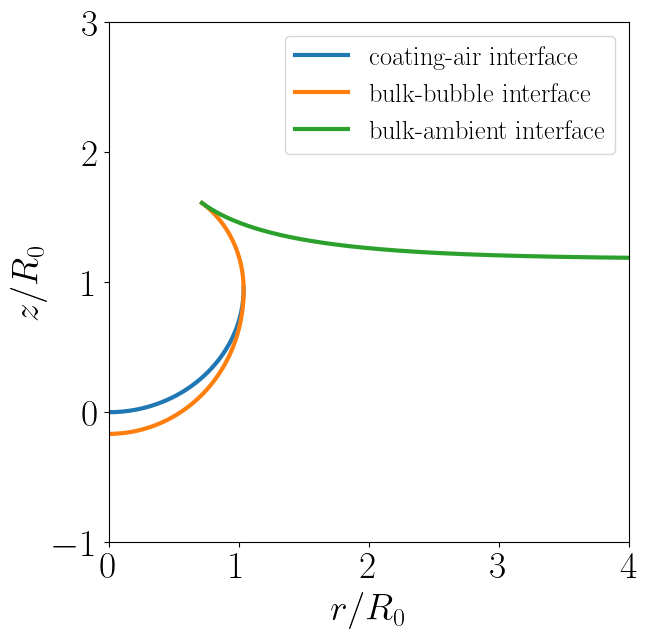

In [2]:
# Define plotting parameters
plt_params = {
    "Rmin": 0.0, "Rmax": 2e0,
    "Zmin": -1e0, "Zmax": 3.5e0
}

fig, ax = prepare_plot(plt_params)

r_ca, z_ca, ang_ca = load_and_sort_data("CaseI_VeryThinLayer_PEO0.2wt/02pcPEO_OF0088_OA.csv")
ax.plot(r_ca, z_ca, label="OA")

r_bb, z_bb, ang_bb = load_and_sort_data("CaseI_VeryThinLayer_PEO0.2wt/02pcPEO_OF0088_OW.csv")
ax.plot(r_bb, z_bb,  label="OW")

min_dist_index, min_distance = calculate_closest_approach(r_ca, z_ca, r_bb, z_bb)
rInt = (r_ca[min_dist_index[0]] + r_bb[min_dist_index[1]]) / 2
zInt = (z_ca[min_dist_index[0]] + z_bb[min_dist_index[1]]) / 2

ax.plot(rInt, zInt, 'o', color='red', label='Closest approach')

r_bubble, z_bubble, ang_bubble = extract_and_combine_segments(r_ca, z_ca, ang_ca, r_bb, z_bb, ang_bb, min_dist_index)

## This part of the code is only to find a typical length scale based on the bubble volume
r0, z0, theta0 = r_bubble[-1], z_bubble[-1], ang_bubble[-1]
Radius = -r0/np.sin(theta0) # radius of curvature
zc = z0 - Radius*np.cos(theta0) # Z coordinate of the center of the bubble circle 
suppAngle = np.linspace(theta0, np.pi, 1000)-np.pi/2

r_bubble = np.concatenate((r_bubble, - Radius * np.cos(suppAngle)))
z_bubble = np.concatenate((z_bubble, zc - Radius * np.sin(suppAngle)))
ang_bubble = np.concatenate((ang_bubble, suppAngle))

ax.plot(r_bubble, z_bubble, 'k--', label='Bubble')

from scipy.integrate import cumtrapz
# volume of the bubble (r_bubble, z_bubble) in cyclindrical coordinates
Vol = np.pi*cumtrapz(r_bubble**2, z_bubble, initial=0)
print('Volume = ', Vol[-1])

# typical length scale 
R0 = (3*Vol[-1]/4/np.pi)**(1/3)
print('Requiv = ', R0)

ax.legend()
plt.show()

# Define plotting parameters
plt_params = {
    "Rmin": 0.0, "Rmax": 4e0,
    "Zmin": -1e0, "Zmax": 3e0
}

fig, ax = prepare_plot(plt_params)
r_ca, z_ca, ang_ca = load_and_sort_data("CaseI_VeryThinLayer_PEO0.2wt/02pcPEO_OF0088_OA.csv")
r_ca, z_ca = r_ca/R0, z_ca/R0
ax.plot(r_ca, z_ca, label="coating-air interface")

r_bb, z_bb, ang_bb = load_and_sort_data("CaseI_VeryThinLayer_PEO0.2wt/02pcPEO_OF0088_OW.csv")
r_bb, z_bb = r_bb/R0, z_bb/R0
ax.plot(r_bb, z_bb,  label="bulk-bubble interface")

r_ba, z_ba, ang_ba = load_and_sort_data("CaseI_VeryThinLayer_PEO0.2wt/02pcPEO_OF0088_WA.csv")
r_ba, z_ba = r_ba/R0, z_ba/R0
ax.plot(r_ba, z_ba,  label="bulk-ambient interface")

# tathered legend to the top right corner outsize the plot
plt.legend(loc='upper right')
plt.savefig('CaseI_VeryThinLayer_PEO0.2wt/shape.pdf', bbox_inches='tight')
plt.show()

### Case II: CaseII_thickLayer_PIB_PEO0.2wt%

Volume =  19.550764700002116
Requiv =  1.6711869918053919


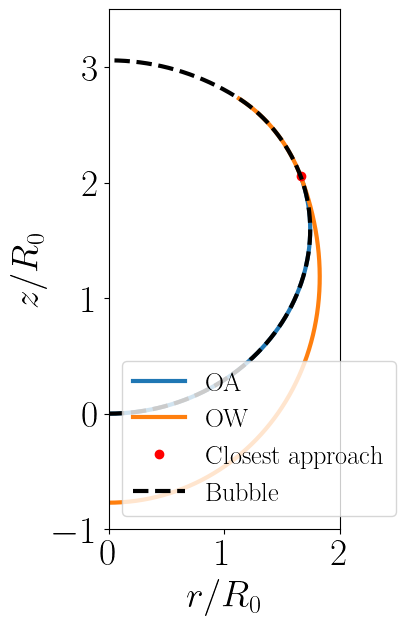

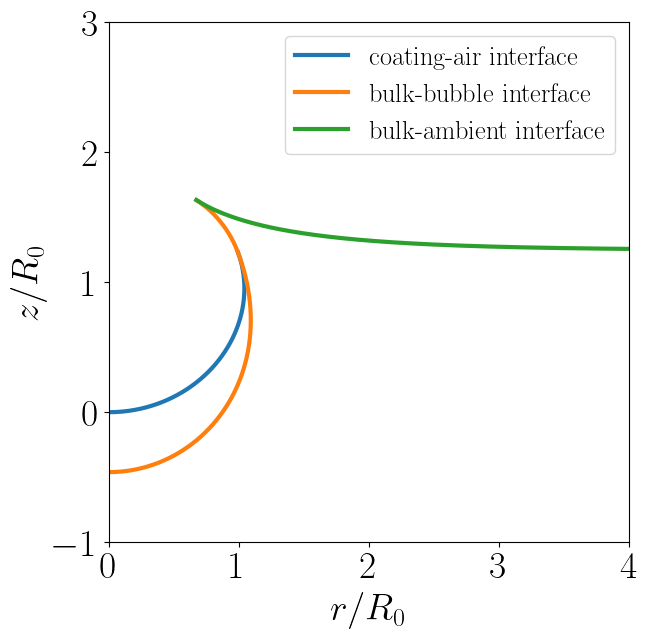

In [7]:
# Define plotting parameters
plt_params = {
    "Rmin": 0.0, "Rmax": 2e0,
    "Zmin": -1e0, "Zmax": 3.5e0
}

fig, ax = prepare_plot(plt_params)

r_ca, z_ca, ang_ca = load_and_sort_data("CaseII_thickLayer_PIB_PEO0.2wt/02pcPEO_OF03125_OA.csv")
ax.plot(r_ca, z_ca, label="OA")

r_bb, z_bb, ang_bb = load_and_sort_data("CaseII_thickLayer_PIB_PEO0.2wt/02pcPEO_OF03125_OW.csv")
ax.plot(r_bb, z_bb,  label="OW")

min_dist_index, min_distance = calculate_closest_approach(r_ca, z_ca, r_bb, z_bb)
rInt = (r_ca[min_dist_index[0]] + r_bb[min_dist_index[1]]) / 2
zInt = (z_ca[min_dist_index[0]] + z_bb[min_dist_index[1]]) / 2

ax.plot(rInt, zInt, 'o', color='red', label='Closest approach')

r_bubble, z_bubble, ang_bubble = extract_and_combine_segments(r_ca, z_ca, ang_ca, r_bb, z_bb, ang_bb, min_dist_index)

## This part of the code is only to find a typical length scale based on the bubble volume
r0, z0, theta0 = r_bubble[-1], z_bubble[-1], ang_bubble[-1]
Radius = -r0/np.sin(theta0) # radius of curvature
zc = z0 - Radius*np.cos(theta0) # Z coordinate of the center of the bubble circle 
suppAngle = np.linspace(theta0, np.pi, 1000)-np.pi/2

r_bubble = np.concatenate((r_bubble, - Radius * np.cos(suppAngle)))
z_bubble = np.concatenate((z_bubble, zc - Radius * np.sin(suppAngle)))
ang_bubble = np.concatenate((ang_bubble, suppAngle))

ax.plot(r_bubble, z_bubble, 'k--', label='Bubble')

from scipy.integrate import cumtrapz
# volume of the bubble (r_bubble, z_bubble) in cyclindrical coordinates
Vol = np.pi*cumtrapz(r_bubble**2, z_bubble, initial=0)
print('Volume = ', Vol[-1])

# typical length scale 
R0 = (3*Vol[-1]/4/np.pi)**(1/3)
print('Requiv = ', R0)

ax.legend()
plt.show()

# Define plotting parameters
plt_params = {
    "Rmin": 0.0, "Rmax": 4e0,
    "Zmin": -1e0, "Zmax": 3e0
}

fig, ax = prepare_plot(plt_params)
r_ca, z_ca, ang_ca = load_and_sort_data("CaseII_thickLayer_PIB_PEO0.2wt/02pcPEO_OF03125_OA.csv")
r_ca, z_ca = r_ca/R0, z_ca/R0
ax.plot(r_ca, z_ca, label="coating-air interface")

r_bb, z_bb, ang_bb = load_and_sort_data("CaseII_thickLayer_PIB_PEO0.2wt/02pcPEO_OF03125_OW.csv")
r_bb, z_bb = r_bb/R0, z_bb/R0
ax.plot(r_bb, z_bb,  label="bulk-bubble interface")

r_ba, z_ba, ang_ba = load_and_sort_data("CaseII_thickLayer_PIB_PEO0.2wt/02pcPEO_OF03125_WA.csv")
r_ba, z_ba = r_ba/R0, z_ba/R0
ax.plot(r_ba, z_ba,  label="bulk-ambient interface")

# tathered legend to the top right corner outsize the plot
plt.legend(loc='upper right')
plt.savefig('CaseII_thickLayer_PIB_PEO0.2wt/shape.pdf', bbox_inches='tight')
plt.show()

### Case III: CaseIII_VeryThinLayer_2PIB_OF000018

Volume =  13.85131714837655
Requiv =  1.4898212161426085


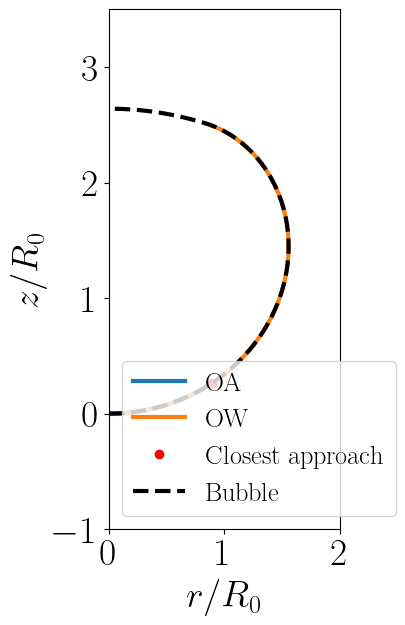

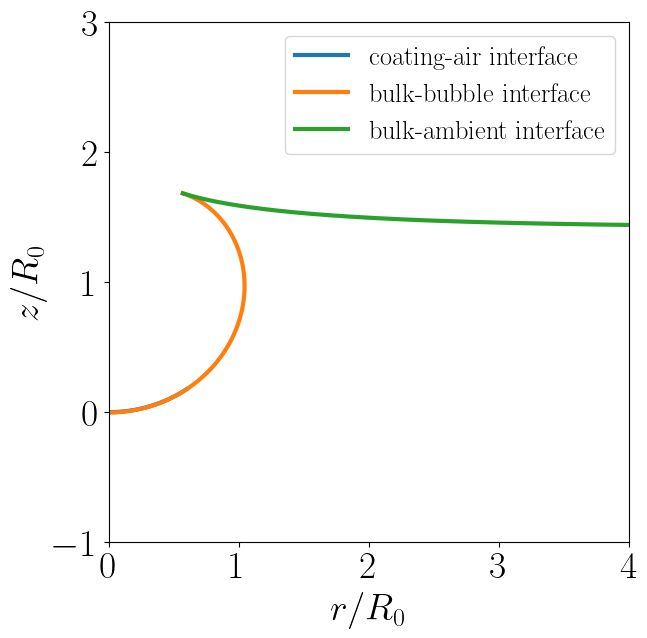

In [6]:
# Define plotting parameters
plt_params = {
    "Rmin": 0.0, "Rmax": 2e0,
    "Zmin": -1e0, "Zmax": 3.5e0
}

fig, ax = prepare_plot(plt_params)

r_ca, z_ca, ang_ca = load_and_sort_data("CaseIII_VeryThinLayer_PIB_Hexa2wt/2PIB_OF000018_OA.csv")
ax.plot(r_ca, z_ca, label="OA")

r_bb, z_bb, ang_bb = load_and_sort_data("CaseIII_VeryThinLayer_PIB_Hexa2wt/2PIB_OF000018_OW.csv")
ax.plot(r_bb, z_bb,  label="OW")

min_dist_index, min_distance = calculate_closest_approach(r_ca, z_ca, r_bb, z_bb)
rInt = (r_ca[min_dist_index[0]] + r_bb[min_dist_index[1]]) / 2
zInt = (z_ca[min_dist_index[0]] + z_bb[min_dist_index[1]]) / 2

ax.plot(rInt, zInt, 'o', color='red', label='Closest approach')

r_bubble, z_bubble, ang_bubble = extract_and_combine_segments(r_ca, z_ca, ang_ca, r_bb, z_bb, ang_bb, min_dist_index)

## This part of the code is only to find a typical length scale based on the bubble volume
r0, z0, theta0 = r_bubble[-1], z_bubble[-1], ang_bubble[-1]
Radius = -r0/np.sin(theta0) # radius of curvature
zc = z0 - Radius*np.cos(theta0) # Z coordinate of the center of the bubble circle 
suppAngle = np.linspace(theta0, np.pi, 1000)-np.pi/2

r_bubble = np.concatenate((r_bubble, - Radius * np.cos(suppAngle)))
z_bubble = np.concatenate((z_bubble, zc - Radius * np.sin(suppAngle)))
ang_bubble = np.concatenate((ang_bubble, suppAngle))

ax.plot(r_bubble, z_bubble, 'k--', label='Bubble')

from scipy.integrate import cumtrapz
# volume of the bubble (r_bubble, z_bubble) in cyclindrical coordinates
Vol = np.pi*cumtrapz(r_bubble**2, z_bubble, initial=0)
print('Volume = ', Vol[-1])

# typical length scale 
R0 = (3*Vol[-1]/4/np.pi)**(1/3)
print('Requiv = ', R0)

ax.legend()
plt.show()

# Define plotting parameters
plt_params = {
    "Rmin": 0.0, "Rmax": 4e0,
    "Zmin": -1e0, "Zmax": 3e0
}

fig, ax = prepare_plot(plt_params)
r_ca, z_ca, ang_ca = load_and_sort_data("CaseIII_VeryThinLayer_PIB_Hexa2wt/2PIB_OF000018_OA.csv")
r_ca, z_ca = r_ca/R0, z_ca/R0
ax.plot(r_ca, z_ca, label="coating-air interface")

r_bb, z_bb, ang_bb = load_and_sort_data("CaseIII_VeryThinLayer_PIB_Hexa2wt/2PIB_OF000018_OW.csv")
r_bb, z_bb = r_bb/R0, z_bb/R0
ax.plot(r_bb, z_bb,  label="bulk-bubble interface")

r_ba, z_ba, ang_ba = load_and_sort_data("CaseIII_VeryThinLayer_PIB_Hexa2wt/2PIB_OF000018_WA.csv")
r_ba, z_ba = r_ba/R0, z_ba/R0
ax.plot(r_ba, z_ba,  label="bulk-ambient interface")

# tathered legend to the top right corner outsize the plot
plt.legend(loc='upper right')
plt.savefig('CaseIII_VeryThinLayer_PIB_Hexa2wt/shape.pdf', bbox_inches='tight')
plt.show()

### Case IV: CaseIV_thickLayer_PIB_Hexa2wt%

Volume =  16.030909524773836
Requiv =  1.5641912467964705


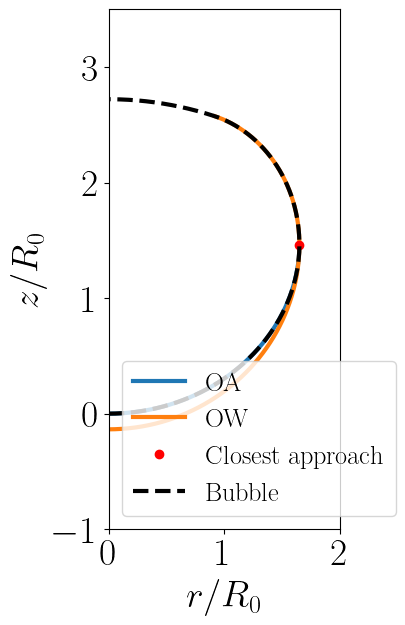

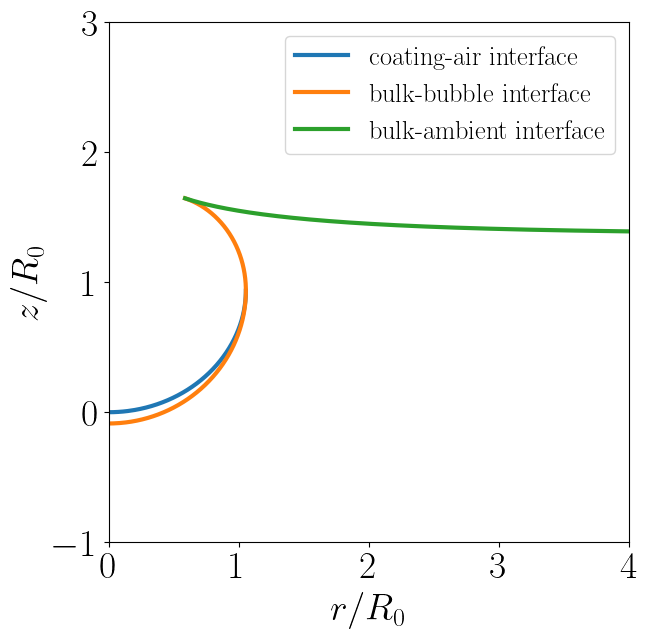

In [8]:
# Define plotting parameters
plt_params = {
    "Rmin": 0.0, "Rmax": 2e0,
    "Zmin": -1e0, "Zmax": 3.5e0
}

fig, ax = prepare_plot(plt_params)

r_ca, z_ca, ang_ca = load_and_sort_data("CaseIV_thickLayer_PIB_Hexa2wt/2PIB_OF00426_OA.csv")
ax.plot(r_ca, z_ca, label="OA")

r_bb, z_bb, ang_bb = load_and_sort_data("CaseIV_thickLayer_PIB_Hexa2wt/2PIB_OF00426_OW.csv")
ax.plot(r_bb, z_bb,  label="OW")

min_dist_index, min_distance = calculate_closest_approach(r_ca, z_ca, r_bb, z_bb)
rInt = (r_ca[min_dist_index[0]] + r_bb[min_dist_index[1]]) / 2
zInt = (z_ca[min_dist_index[0]] + z_bb[min_dist_index[1]]) / 2

ax.plot(rInt, zInt, 'o', color='red', label='Closest approach')

r_bubble, z_bubble, ang_bubble = extract_and_combine_segments(r_ca, z_ca, ang_ca, r_bb, z_bb, ang_bb, min_dist_index)

## This part of the code is only to find a typical length scale based on the bubble volume
r0, z0, theta0 = r_bubble[-1], z_bubble[-1], ang_bubble[-1]
Radius = -r0/np.sin(theta0) # radius of curvature
zc = z0 - Radius*np.cos(theta0) # Z coordinate of the center of the bubble circle 
suppAngle = np.linspace(theta0, np.pi, 1000)-np.pi/2

r_bubble = np.concatenate((r_bubble, - Radius * np.cos(suppAngle)))
z_bubble = np.concatenate((z_bubble, zc - Radius * np.sin(suppAngle)))
ang_bubble = np.concatenate((ang_bubble, suppAngle))

ax.plot(r_bubble, z_bubble, 'k--', label='Bubble')

df = pd.DataFrame({'z': z_bubble, 'r': r_bubble})
df.to_csv('CaseIV_thickLayer_PIB_Hexa2wt/bubble.dat', index=False, float_format='%.6f', sep=' ', header=False)

from scipy.integrate import cumtrapz
# volume of the bubble (r_bubble, z_bubble) in cyclindrical coordinates
Vol = np.pi*cumtrapz(r_bubble**2, z_bubble, initial=0)
print('Volume = ', Vol[-1])

# typical length scale 
R0 = (3*Vol[-1]/4/np.pi)**(1/3)
print('Requiv = ', R0)

ax.legend()
plt.show()

# Define plotting parameters
plt_params = {
    "Rmin": 0.0, "Rmax": 4e0,
    "Zmin": -1e0, "Zmax": 3e0
}

fig, ax = prepare_plot(plt_params)
r_ca, z_ca, ang_ca = load_and_sort_data("CaseIV_thickLayer_PIB_Hexa2wt/2PIB_OF00426_OA.csv")
r_ca, z_ca = r_ca/R0, z_ca/R0
ax.plot(r_ca, z_ca, label="coating-air interface")

r_bb, z_bb, ang_bb = load_and_sort_data("CaseIV_thickLayer_PIB_Hexa2wt/2PIB_OF00426_OW.csv")
r_bb, z_bb = r_bb/R0, z_bb/R0
ax.plot(r_bb, z_bb,  label="bulk-bubble interface")

r_ba, z_ba, ang_ba = load_and_sort_data("CaseIV_thickLayer_PIB_Hexa2wt/2PIB_OF00426_WA.csv")
r_ba, z_ba = r_ba/R0, z_ba/R0
ax.plot(r_ba, z_ba,  label="bulk-ambient interface")

# tathered legend to the top right corner outsize the plot
plt.legend(loc='upper right')
plt.savefig('CaseIV_thickLayer_PIB_Hexa2wt/shape.pdf', bbox_inches='tight')
plt.show()

### Saving data files to import initial shapes to Basilisk

In [9]:
from scipy.optimize import minimize

def create_circular_fillet(r_bb, r_ba, ang_bb, ang_ba, z_bb, z_ba, num_points=15, chop_phi=0.01):

    threshold_bb = ang_bb[-1] - chop_phi * np.pi
    chop_pointsbb = np.where(ang_bb < threshold_bb)[0]
    chop_pointsbb = chop_pointsbb[-1] if chop_pointsbb.size > 0 else 0
    
    threshold_ba = ang_ba[0] + chop_phi * np.pi
    chop_pointsba = np.where(ang_ba > threshold_ba)[0]
    chop_pointsba = chop_pointsba[0] if chop_pointsba.size > 0 else len(ang_ba)

    r_fillet = np.concatenate((r_bb[chop_pointsbb:], r_ba[:chop_pointsba]))
    ang_fillet = np.concatenate((ang_bb[chop_pointsbb:], ang_ba[:chop_pointsba]))
    z_fillet = np.concatenate((z_bb[chop_pointsbb:], z_ba[:chop_pointsba]))

    # Function to fit a circle to three points
    def fit_circle_3points(p1, p2, p3):
        temp = p2[0] * p2[0] + p2[1] * p2[1]
        bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
        cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
        det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])
        
        if abs(det) < 1.0e-6:
            return np.inf, np.inf, np.inf
        
        cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
        cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det
        radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
        return cx, cy, radius

    # Fit circle to start, middle, and end points of the fillet
    start = np.array([r_fillet[0], z_fillet[0]])
    middle = np.array([r_fillet[len(r_fillet)//2], z_fillet[len(z_fillet)//2]])
    end = np.array([r_fillet[-1], z_fillet[-1]])
    
    r0, z0, radius = fit_circle_3points(start, middle, end)

    # Generate points on the fitted circle
    theta_start = np.arctan2(z_fillet[0] - z0, r_fillet[0] - r0)
    theta_end = np.arctan2(z_fillet[-1] - z0, r_fillet[-1] - r0)
    
    if theta_end < theta_start:
        theta_end += 2 * np.pi
    
    theta = np.linspace(theta_start, theta_end, num_points)
    r_circle = r0 + radius * np.cos(theta)
    z_circle = z0 + radius * np.sin(theta)
    
    # Interpolate angles for the circle points
    ang_circle = np.interp(theta, [theta_start, theta_end], [ang_fillet[0], ang_fillet[-1]])

    # Combine the fitted circle with the original points
    r_final = np.concatenate((r_bb[:chop_pointsbb], r_circle, r_ba[chop_pointsba:]))
    z_final = np.concatenate((z_bb[:chop_pointsbb], z_circle, z_ba[chop_pointsba:]))
    ang_final = np.concatenate((ang_bb[:chop_pointsbb], ang_circle, ang_ba[chop_pointsba:]))

    return r_final, ang_final, z_final


def create_circular_fillet_dewet(r_f2, r_ca, ang_f2, ang_ca, z_f2, z_ca, num_points=15, chop_phi=0.01):
    r_ca, ang_ca, z_ca = r_ca[::-1], ang_ca[::-1], z_ca[::-1]

    threshold_f2 = ang_f2[-1] - chop_phi * np.pi*0.78
    chop_pointsf2 = np.where(ang_f2 < threshold_f2)[0]
    chop_pointsf2 = chop_pointsf2[-1] if chop_pointsf2.size > 0 else 0

    threshold_ca = ang_ca[0] - chop_phi * np.pi
    chop_pointsca = np.where(ang_ca < threshold_ca)[0]
    chop_pointsca = chop_pointsca[0] if chop_pointsca.size > 0 else 0

    r_fillet = np.concatenate((r_f2[chop_pointsf2:], r_ca[:chop_pointsca]))
    ang_fillet = np.concatenate((ang_f2[chop_pointsf2:], ang_ca[:chop_pointsca]))
    z_fillet = np.concatenate((z_f2[chop_pointsf2:], z_ca[:chop_pointsca]))

    # Function to fit a circular arc to endpoints and tangents
    def fit_circular_arc(p1, t1, p2, t2, num_points):
        # Calculate the center of the circle
        A = np.array([
            [2 * (p2[0] - p1[0]), 2 * (p2[1] - p1[1])],
            [2 * (t2[0] - t1[0]), 2 * (t2[1] - t1[1])]
        ])
        b = np.array([
            p2[0]**2 + p2[1]**2 - p1[0]**2 - p1[1]**2,
            t2[0]**2 + t2[1]**2 - t1[0]**2 - t1[1]**2
        ])
        center = np.linalg.solve(A, b)

        # Calculate the radius of the circle
        radius = np.sqrt((center[0] - p1[0])**2 + (center[1] - p1[1])**2)

        # Calculate the angles for the arc
        theta1 = np.arctan2(p1[1] - center[1], p1[0] - center[0])
        theta2 = np.arctan2(p2[1] - center[1], p2[0] - center[0])
        if theta2 < theta1:
            theta2 += 2 * np.pi

        theta = np.linspace(theta1, theta2, num_points)
        r_circle = center[0] + radius * np.cos(theta)
        z_circle = center[1] + radius * np.sin(theta)

        return r_circle, z_circle

    # Start and end points
    start = np.array([r_fillet[0], z_fillet[0]])
    end = np.array([r_fillet[-1], z_fillet[-1]])

    # Tangents at start and end points (approximated by finite differences)
    t1 = np.array([r_fillet[1] - r_fillet[0], z_fillet[1] - z_fillet[0]])
    t2 = np.array([r_fillet[-1] - r_fillet[-2], z_fillet[-1] - z_fillet[-2]])

    # Fit circular arc with tangents
    r_circle, z_circle = fit_circular_arc(start, t1, end, t2, num_points)

    # Interpolate angles for the circle points
    ang_circle = np.interp(np.linspace(0, 1, num_points), [0, 1], [ang_fillet[0], ang_fillet[-1]])

    r_final = np.concatenate((r_f2[:chop_pointsf2], r_circle, r_ca[chop_pointsca:]))
    ang_final = np.concatenate((ang_f2[:chop_pointsf2], ang_circle, ang_ca[chop_pointsca:]))
    z_final = np.concatenate((z_f2[:chop_pointsf2], z_circle, z_ca[chop_pointsca:]))

    return r_final, ang_final, z_final

### For cases I and II: bulk must form a precursor layer!

### Case I: CaseI_VeryThinLayer_PEO0.2wt

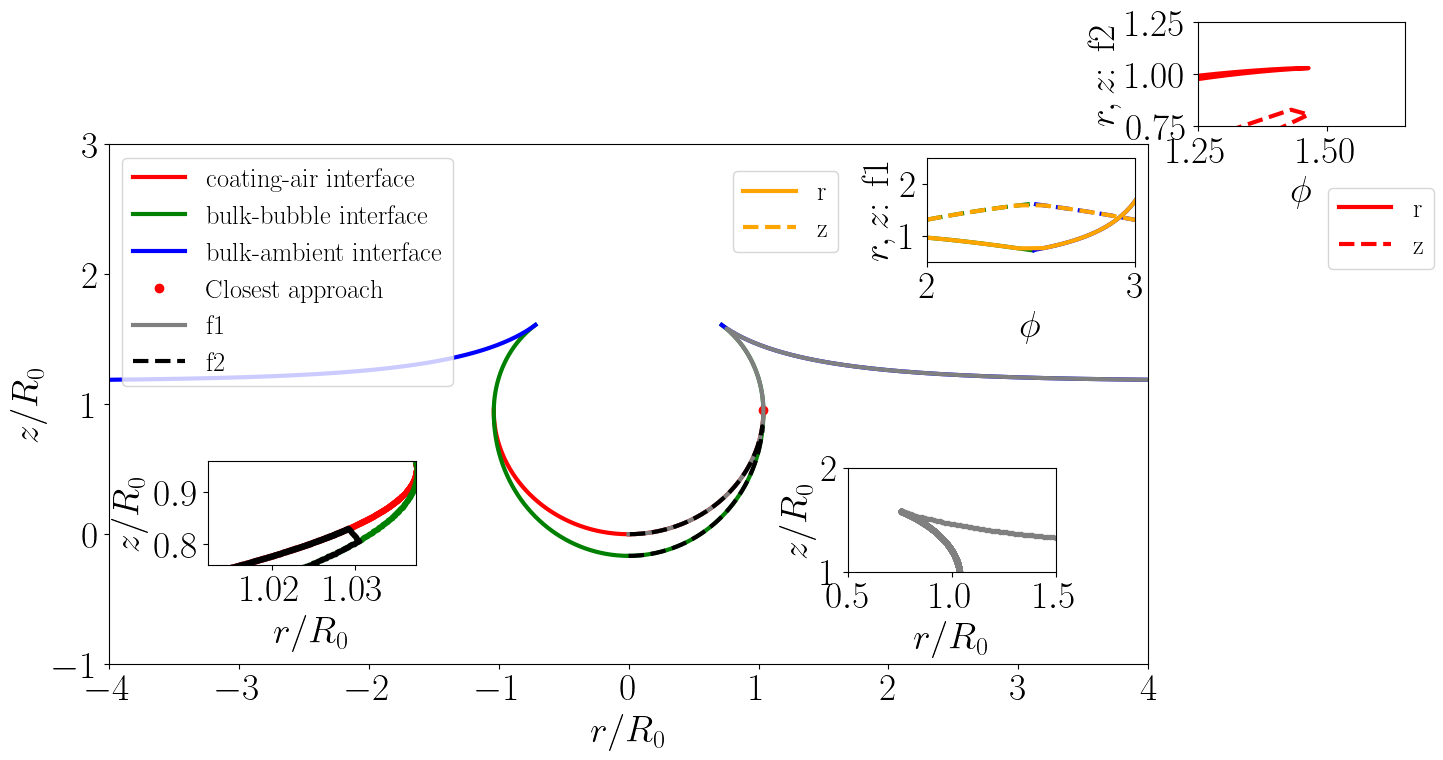

In [10]:
R0 = 1.7928419584511264 # from the previous cell

# Define plotting parameters
plt_params = {
    "Rmin": -4e0, "Rmax": 4e0,
    "Zmin": -1e0, "Zmax": 3e0
}

fig, ax = prepare_plot(plt_params)
r_ca, z_ca, ang_ca = load_and_sort_data("CaseI_VeryThinLayer_PEO0.2wt/02pcPEO_OF0088_OA.csv")
r_ca, z_ca = r_ca/R0, z_ca/R0
ax.plot(r_ca, z_ca, 'r-', label="coating-air interface")
ax.plot(-r_ca, z_ca, 'r-', label="_coating-air interface")

r_bb, z_bb, ang_bb = load_and_sort_data("CaseI_VeryThinLayer_PEO0.2wt/02pcPEO_OF0088_OW.csv")
r_bb, z_bb = r_bb/R0, z_bb/R0
ax.plot(r_bb, z_bb, 'g-',  label="bulk-bubble interface")
ax.plot(-r_bb, z_bb, 'g-',  label="_bulk-bubble interface")

r_ba, z_ba, ang_ba = load_and_sort_data("CaseI_VeryThinLayer_PEO0.2wt/02pcPEO_OF0088_WA.csv")
r_ba, z_ba = r_ba/R0, z_ba/R0
ang_ba += np.pi
ax.plot(r_ba, z_ba, 'b-',  label="bulk-ambient interface")
ax.plot(-r_ba, z_ba, 'b-',  label="_bulk-ambient interface")

min_dist_index, min_distance = calculate_closest_approach(r_ca, z_ca, r_bb, z_bb)
rInt = (r_ca[min_dist_index[0]] + r_bb[min_dist_index[1]]) / 2
zInt = (z_ca[min_dist_index[0]] + z_bb[min_dist_index[1]]) / 2
ax.plot(rInt, zInt, 'o', color='red', label='Closest approach')

# combine r_bb and r_ba
r_f1, z_f1, ang_f1 = extract_and_combine_segments(r_ca, z_ca, ang_ca, r_bb, z_bb, ang_bb, min_dist_index)
r_f1, ang_f1, z_f1 = create_circular_fillet(r_f1, r_ba, ang_f1, ang_ba, z_f1, z_ba, chop_phi=0.02)

ax.plot(r_f1, z_f1, '-', color='gray', label='f1')

df = pd.DataFrame({'z': z_f1, 'r': r_f1})

df.to_csv('CaseI_VeryThinLayer_PEO0.2wt/f1.dat', index=False, sep=' ', header=False)


# flip the arrays upside down
r_f2, z_f2, ang_f2 = r_bb[:min_dist_index[1]], z_bb[:min_dist_index[1]], ang_bb[:min_dist_index[1]]
# r_f2, z_f2, ang_f2 = r_f2[::-1], z_f2[::-1], ang_f2[::-1]
r_f2, ang_f2, z_f2 = create_circular_fillet_dewet(r_f2, r_ca, ang_f2, ang_ca, z_f2, z_ca, chop_phi=0.05)
ax.plot(r_f2, z_f2, '--', color='black', label='f2')

df = pd.DataFrame({'z': z_f2, 'r': r_f2})
# 
df.to_csv('CaseI_VeryThinLayer_PEO0.2wt/f2.dat', index=False, sep=' ', header=False)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Create an inset with specific dimensions and position
axins = inset_axes(ax, width="20%", height="20%", loc='upper right')
# Plot on the inset
axins.plot(ang_bb, r_bb, '-', color='green', label='_r_bb')
axins.plot(ang_bb, z_bb, '--', color='green', label='_z_bb')
axins.plot(ang_ba, r_ba, '-', color='blue', label='_r_ba')
axins.plot(ang_ba, z_ba, '--', color='blue', label='_z_ba')

axins.plot(ang_f1, r_f1, '-', color='orange', label='r')
axins.plot(ang_f1, z_f1, '--', color='orange', label='z')


axins.set_xlim(2.0, 3.0)
axins.set_ylim(0.5, 2.5)
axins.set_xlabel(r'$\phi$')
axins.set_ylabel(r'$r, z$: f1')
axins.legend(loc='upper left', bbox_to_anchor=(-1.0, 1.0))

# Create an inset with specific dimensions and position
axins = inset_axes(ax, width="100%", height="100%", 
                   loc='upper right', 
                   bbox_to_anchor=(1.06, 1.06, 0.2, 0.2), 
                   bbox_transform=ax.transAxes)

# Plot on the inset
axins.plot(ang_f2, r_f2, '-', color='red', label='r')
axins.plot(ang_f2, z_f2, '--', color='red', label='z')

axins.set_xlim(1.25, 1.65)
axins.set_ylim(0.75, 1.25)
axins.set_xlabel(r'$\phi$')
axins.set_ylabel(r'$r, z$: f2')
axins.legend(loc='lower right', bbox_to_anchor=(1.2, -1.5))

# Create an inset with specific dimensions and position
axins = inset_axes(ax, width="20%", height="20%", loc='lower right', borderpad=3.5)
# Plot on the inset
axins.plot(r_f1, z_f1, '.', color='gray', label='f2')
axins.set_xlim(0.5, 1.50)
axins.set_ylim(1.0, 2.00)
axins.set_xlabel(r'$r/R_0$')
axins.set_ylabel(r'$z/R_0$')

axins = inset_axes(ax, width="20%", height="20%", loc='lower left', borderpad=3.75)
# Plot on the inset
axins.plot(r_ca, z_ca, '.', color='red', label='r_ca')
axins.plot(r_bb, z_bb, '.', color='green', label='r_bb')
axins.plot(r_f2, z_f2, '.', color='black', label='f2')
axins.set_xlim(rInt-0.025, rInt)
axins.set_ylim(zInt-0.20, zInt)
axins.set_xlabel(r'$r/R_0$')
axins.set_ylabel(r'$z/R_0$')

ax.legend(loc='upper left')

plt.savefig('CaseI_VeryThinLayer_PEO0.2wt/shape_details.pdf', bbox_inches='tight')
plt.show()

### Case II: CaseII_thickLayer_PIB_PEO0.2wt

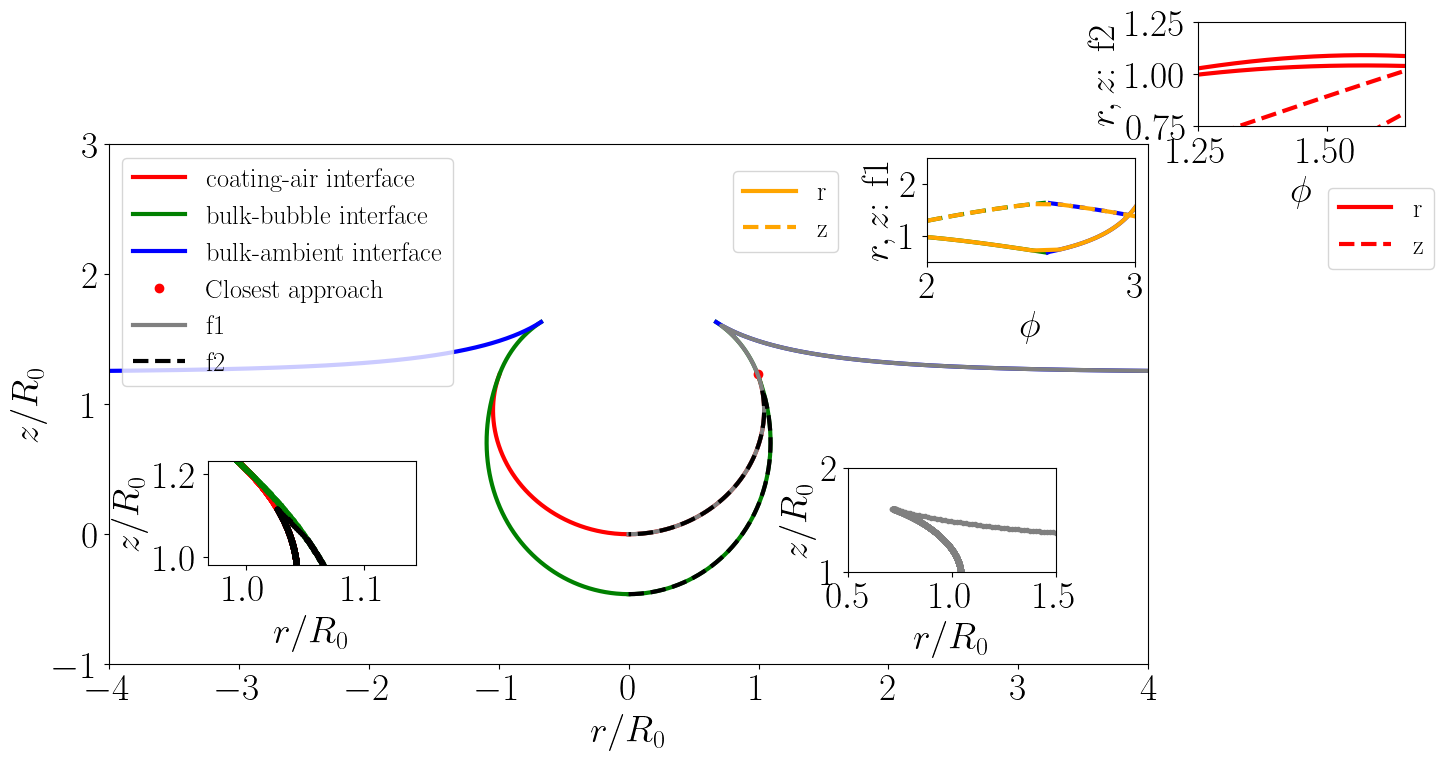

In [20]:
R0 = 1.6711869918053919 # from the previous cell

# Define plotting parameters
plt_params = {
    "Rmin": -4e0, "Rmax": 4e0,
    "Zmin": -1e0, "Zmax": 3e0
}

fig, ax = prepare_plot(plt_params)
r_ca, z_ca, ang_ca = load_and_sort_data("CaseII_thickLayer_PIB_PEO0.2wt/02pcPEO_OF03125_OA.csv")
r_ca, z_ca = r_ca/R0, z_ca/R0
ax.plot(r_ca, z_ca, 'r-', label="coating-air interface")
ax.plot(-r_ca, z_ca, 'r-', label="_coating-air interface")

r_bb, z_bb, ang_bb = load_and_sort_data("CaseII_thickLayer_PIB_PEO0.2wt/02pcPEO_OF03125_OW.csv")
r_bb, z_bb = r_bb/R0, z_bb/R0
ax.plot(r_bb, z_bb, 'g-',  label="bulk-bubble interface")
ax.plot(-r_bb, z_bb, 'g-',  label="_bulk-bubble interface")

r_ba, z_ba, ang_ba = load_and_sort_data("CaseII_thickLayer_PIB_PEO0.2wt/02pcPEO_OF03125_WA.csv")
r_ba, z_ba = r_ba/R0, z_ba/R0
ang_ba += np.pi
ax.plot(r_ba, z_ba, 'b-',  label="bulk-ambient interface")
ax.plot(-r_ba, z_ba, 'b-',  label="_bulk-ambient interface")

min_dist_index, min_distance = calculate_closest_approach(r_ca, z_ca, r_bb, z_bb)
rInt = (r_ca[min_dist_index[0]] + r_bb[min_dist_index[1]]) / 2
zInt = (z_ca[min_dist_index[0]] + z_bb[min_dist_index[1]]) / 2
ax.plot(rInt, zInt, 'o', color='red', label='Closest approach')

# combine r_bb and r_ba
r_f1, z_f1, ang_f1 = extract_and_combine_segments(r_ca, z_ca, ang_ca, r_bb, z_bb, ang_bb, min_dist_index)
r_f1, ang_f1, z_f1 = create_circular_fillet(r_f1, r_ba, ang_f1, ang_ba, z_f1, z_ba, chop_phi=0.02)

ax.plot(r_f1, z_f1, '-', color='gray', label='f1')

df = pd.DataFrame({'z': z_f1, 'r': r_f1})

df.to_csv('CaseII_thickLayer_PIB_PEO0.2wt/f1.dat', index=False, sep=' ', header=False)


# flip the arrays upside down
r_f2, z_f2, ang_f2 = r_bb[:min_dist_index[1]], z_bb[:min_dist_index[1]], ang_bb[:min_dist_index[1]]
# r_f2, z_f2, ang_f2 = r_f2[::-1], z_f2[::-1], ang_f2[::-1]
r_f2, ang_f2, z_f2 = create_circular_fillet_dewet(r_f2, r_ca, ang_f2, ang_ca, z_f2, z_ca, chop_phi=0.05)
ax.plot(r_f2, z_f2, '--', color='black', label='f2')

df = pd.DataFrame({'z': z_f2, 'r': r_f2})
# 
df.to_csv('CaseII_thickLayer_PIB_PEO0.2wt/f2.dat', index=False, sep=' ', header=False)

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Create an inset with specific dimensions and position
axins = inset_axes(ax, width="20%", height="20%", loc='upper right')
# Plot on the inset
axins.plot(ang_bb, r_bb, '-', color='green', label='_r_bb')
axins.plot(ang_bb, z_bb, '--', color='green', label='_z_bb')
axins.plot(ang_ba, r_ba, '-', color='blue', label='_r_ba')
axins.plot(ang_ba, z_ba, '--', color='blue', label='_z_ba')

axins.plot(ang_f1, r_f1, '-', color='orange', label='r')
axins.plot(ang_f1, z_f1, '--', color='orange', label='z')


axins.set_xlim(2.0, 3.0)
axins.set_ylim(0.5, 2.5)
axins.set_xlabel(r'$\phi$')
axins.set_ylabel(r'$r, z$: f1')
axins.legend(loc='upper left', bbox_to_anchor=(-1.0, 1.0))

# Create an inset with specific dimensions and position
axins = inset_axes(ax, width="100%", height="100%", 
                   loc='upper right', 
                   bbox_to_anchor=(1.06, 1.06, 0.2, 0.2), 
                   bbox_transform=ax.transAxes)

# Plot on the inset
axins.plot(ang_f2, r_f2, '-', color='red', label='r')
axins.plot(ang_f2, z_f2, '--', color='red', label='z')

axins.set_xlim(1.25, 1.65)
axins.set_ylim(0.75, 1.25)
axins.set_xlabel(r'$\phi$')
axins.set_ylabel(r'$r, z$: f2')
axins.legend(loc='lower right', bbox_to_anchor=(1.2, -1.5))

# Create an inset with specific dimensions and position
axins = inset_axes(ax, width="20%", height="20%", loc='lower right', borderpad=3.5)
# Plot on the inset
axins.plot(r_f1, z_f1, '.', color='gray', label='f2')
axins.set_xlim(0.5, 1.50)
axins.set_ylim(1.0, 2.00)
axins.set_xlabel(r'$r/R_0$')
axins.set_ylabel(r'$z/R_0$')

axins = inset_axes(ax, width="20%", height="20%", loc='lower left', borderpad=3.75)
# Plot on the inset
axins.plot(r_ca, z_ca, '.', color='red', label='r_ca')
axins.plot(r_bb, z_bb, '.', color='green', label='r_bb')
axins.plot(r_f2, z_f2, '.', color='black', label='f2')
axins.set_xlim(rInt-0.025, rInt+0.15)
axins.set_ylim(zInt-0.25, zInt)
axins.set_xlabel(r'$r/R_0$')
axins.set_ylabel(r'$z/R_0$')

ax.legend(loc='upper left')

plt.savefig('CaseII_thickLayer_PIB_PEO0.2wt/shape_details.pdf', bbox_inches='tight')
plt.show()

### For cases III and IV: the coating must form a precursor layer!

### Case III: CaseIII_VeryThinLayer_PIB_Hexa2wt%

In [ ]:
R0 = 1.4898212161426085 # from the previous cell

# Define plotting parameters
plt_params = {
    "Rmin": -4e0, "Rmax": 4e0,
    "Zmin": -1e0, "Zmax": 3e0
}
fig, ax = prepare_plot(plt_params)
r_ca, z_ca, ang_ca = load_and_sort_data("CaseIII_VeryThinLayer_PIB_Hexa2wt/2PIB_OF000018_OA.csv")
r_ca, z_ca = r_ca/R0, z_ca/R0
ax.plot(r_ca, z_ca, 'r-', label="coating-air interface")
ax.plot(-r_ca, z_ca, 'r-', label="_coating-air interface")

r_bb, z_bb, ang_bb = load_and_sort_data("CaseIII_VeryThinLayer_PIB_Hexa2wt/2PIB_OF000018_OW.csv")
r_bb, z_bb = r_bb/R0, z_bb/R0
ax.plot(r_bb, z_bb, 'g-',  label="bulk-bubble interface")
ax.plot(-r_bb, z_bb, 'g-',  label="_bulk-bubble interface")

r_ba, z_ba, ang_ba = load_and_sort_data("CaseIII_VeryThinLayer_PIB_Hexa2wt/2PIB_OF000018_WA.csv")
r_ba, z_ba = r_ba/R0, z_ba/R0
ang_ba += np.pi
ax.plot(r_ba, z_ba, 'b-',  label="bulk-ambient interface")
ax.plot(-r_ba, z_ba, 'b-',  label="_bulk-ambient interface")

# combine r_bb and r_ba 
# this is the naivee way -> Basilisk does not like to import cusps!
# ang_f2 = np.concatenate((ang_bb[:-10], ang_ba[5:]))
# r_f2 = np.concatenate((r_bb[:-10], r_ba[5:]))
# z_f2 = np.concatenate((z_bb[:-10], z_ba[5:]))

# fillet the connection.. results must be independent of chop_phi if chosen to be small enough... 

r_f2, ang_f2, z_f2 = create_circular_fillet(r_bb, r_ba, ang_bb, ang_ba, z_bb, z_ba, chop_phi=0.02)

ax.plot(r_f2, z_f2, '-', color='gray', label='f2')

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Create an inset with specific dimensions and position
axins = inset_axes(ax, width="20%", height="20%", loc='upper right')
# Plot on the inset
axins.plot(ang_bb, r_bb, '-', color='green', label='_r_bb')
axins.plot(ang_bb, z_bb, '--', color='green', label='_z_bb')
axins.plot(ang_ba, r_ba, '-', color='blue', label='_r_ba')
axins.plot(ang_ba, z_ba, '--', color='blue', label='_z_ba')

axins.plot(ang_f2, r_f2, '-', color='orange', label='r')
axins.plot(ang_f2, z_f2, '--', color='orange', label='z')


axins.set_xlim(2.5, 3.1)
axins.set_ylim(0.5, 2.5)
axins.set_xlabel(r'$\phi$')
axins.set_ylabel(r'$r, z$: f2')
axins.legend(loc='upper left', bbox_to_anchor=(-1.0, 1.0))

# Create an inset with specific dimensions and position
axins = inset_axes(ax, width="20%", height="20%", loc='lower right', borderpad=3.5)
# Plot on the inset
axins.plot(r_f2, z_f2, '.', color='gray', label='f2')
axins.set_xlim(0.5, 1.50)
axins.set_ylim(1.0, 2.00)
axins.set_xlabel(r'$r/R_0$')
axins.set_ylabel(r'$z/R_0$')

df = pd.DataFrame({'z': z_f2, 'r': r_f2})
# 
df.to_csv('CaseIII_VeryThinLayer_PIB_Hexa2wt/f2.dat', index=False, sep=' ', header=False)

min_dist_index, min_distance = calculate_closest_approach(r_ca, z_ca, r_f2, z_f2)
rInt = (r_ca[min_dist_index[0]] + r_bb[min_dist_index[1]]) / 2
zInt = (z_ca[min_dist_index[0]] + z_bb[min_dist_index[1]]) / 2
ax.plot(rInt, zInt, 'o', color='red', label='Closest approach')
r_bubble, z_bubble, ang_bubble = extract_and_combine_segments(r_ca, z_ca, ang_ca, r_f2, z_f2, ang_f2, min_dist_index)
ax.plot(r_bubble, z_bubble, '--', color='black', label='f1')

ax.legend(loc='upper left')

plt.savefig('CaseIII_VeryThinLayer_PIB_Hexa2wt/shape_details.pdf', bbox_inches='tight')
plt.show()

df = pd.DataFrame({'z': z_bubble, 'r': r_bubble})
# 
df.to_csv('CaseIII_VeryThinLayer_PIB_Hexa2wt/f1.dat', index=False, sep=' ', header=False)

### CaseIV_thickLayer_PIB_Hexa2wt%

In [ ]:
R0 = 1.5641912467964705 # from the previous cell

# Define plotting parameters
plt_params = {
    "Rmin": -4e0, "Rmax": 4e0,
    "Zmin": -1e0, "Zmax": 3e0
}

fig, ax = prepare_plot(plt_params)
r_ca, z_ca, ang_ca = load_and_sort_data("CaseIV_thickLayer_PIB_Hexa2wt/2PIB_OF00426_OA.csv")
r_ca, z_ca = r_ca/R0, z_ca/R0
ax.plot(r_ca, z_ca, 'r-', label="coating-air interface")
ax.plot(-r_ca, z_ca, 'r-', label="_coating-air interface")

r_bb, z_bb, ang_bb = load_and_sort_data("CaseIV_thickLayer_PIB_Hexa2wt/2PIB_OF00426_OW.csv")
r_bb, z_bb = r_bb/R0, z_bb/R0
ax.plot(r_bb, z_bb, 'g-',  label="bulk-bubble interface")
ax.plot(-r_bb, z_bb, 'g-',  label="_bulk-bubble interface")

r_ba, z_ba, ang_ba = load_and_sort_data("CaseIV_thickLayer_PIB_Hexa2wt/2PIB_OF00426_WA.csv")
r_ba, z_ba = r_ba/R0, z_ba/R0
ang_ba += np.pi
ax.plot(r_ba, z_ba, 'b-',  label="bulk-ambient interface")
ax.plot(-r_ba, z_ba, 'b-',  label="_bulk-ambient interface")

# combine r_bb and r_ba 
# this is the naivee way -> Basilisk does not like to import cusps!
# ang_f2 = np.concatenate((ang_bb[:-10], ang_ba[5:]))
# r_f2 = np.concatenate((r_bb[:-10], r_ba[5:]))
# z_f2 = np.concatenate((z_bb[:-10], z_ba[5:]))

# fillet the connection.. results must be independent of chop_phi if chosen to be small enough... 

r_f2, ang_f2, z_f2 = create_circular_fillet(r_bb, r_ba, ang_bb, ang_ba, z_bb, z_ba, chop_phi=0.02)

ax.plot(r_f2, z_f2, '-', color='gray', label='f2')

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# Create an inset with specific dimensions and position
axins = inset_axes(ax, width="20%", height="20%", loc='upper right')
# Plot on the inset
axins.plot(ang_bb, r_bb, '-', color='green', label='_r_bb')
axins.plot(ang_bb, z_bb, '--', color='green', label='_z_bb')
axins.plot(ang_ba, r_ba, '-', color='blue', label='_r_ba')
axins.plot(ang_ba, z_ba, '--', color='blue', label='_z_ba')

axins.plot(ang_f2, r_f2, '-', color='orange', label='r')
axins.plot(ang_f2, z_f2, '--', color='orange', label='z')


axins.set_xlim(2.5, 3.1)
axins.set_ylim(0.5, 2.5)
axins.set_xlabel(r'$\phi$')
axins.set_ylabel(r'$r, z$: f2')
axins.legend(loc='upper left', bbox_to_anchor=(-1.0, 1.0))

# Create an inset with specific dimensions and position
axins = inset_axes(ax, width="20%", height="20%", loc='lower right', borderpad=3.5)
# Plot on the inset
axins.plot(r_f2, z_f2, '.', color='gray', label='f2')
axins.set_xlim(0.5, 1.50)
axins.set_ylim(1.0, 2.00)
axins.set_xlabel(r'$r/R_0$')
axins.set_ylabel(r'$z/R_0$')

df = pd.DataFrame({'z': z_f2, 'r': r_f2})
# 
df.to_csv('CaseIV_thickLayer_PIB_Hexa2wt/f2.dat', index=False, sep=' ', header=False)

min_dist_index, min_distance = calculate_closest_approach(r_ca, z_ca, r_f2, z_f2)
rInt = (r_ca[min_dist_index[0]] + r_bb[min_dist_index[1]]) / 2
zInt = (z_ca[min_dist_index[0]] + z_bb[min_dist_index[1]]) / 2
ax.plot(rInt, zInt, 'o', color='red', label='Closest approach')
r_bubble, z_bubble, ang_bubble = extract_and_combine_segments(r_ca, z_ca, ang_ca, r_f2, z_f2, ang_f2, min_dist_index)
ax.plot(r_bubble, z_bubble, '--', color='black', label='f1')

ax.legend(loc='upper left')
plt.savefig('CaseIV_thickLayer_PIB_Hexa2wt/shape_details.pdf', bbox_inches='tight')
plt.show()

df = pd.DataFrame({'z': z_bubble, 'r': r_bubble})
# 
df.to_csv('CaseIV_thickLayer_PIB_Hexa2wt/f1.dat', index=False, sep=' ', header=False)